##### Copyright 2019 The TensorFlow Authors.

In [38]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using Recurrent Neural Networks (RNNs). This is covered in two parts: first, you will forecast a univariate time series, then you will forecast a multivariate time series.

In [39]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
This tutorial uses a [weather time series dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by the [Max-Planck-Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/index.php/Main/HomePage).

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [40]:
all_data = pd.read_csv('asos.csv', na_values=['M'])
df = all_data[['valid','drct', 'sknt', 'alti', 'vsby']].copy()
print(df.isnull().sum(axis = 0))
df = df.dropna()
print(df.isnull().sum(axis = 0))
df = df[df.vsby != 10]

C:\Users\Christopher Kok\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


valid        0
drct     13138
sknt      8276
alti       152
vsby      1195
dtype: int64
valid    0
drct     0
sknt     0
alti     0
vsby     0
dtype: int64


In [41]:
# Removing negative values from visibility
df['vsby'][df['vsby'] < 0] = 0
print(df.describe())
print(df.shape)

                drct           sknt           alti           vsby
count  110540.000000  110540.000000  110540.000000  110540.000000
mean      120.020083      11.371288      29.605425       4.734573
std       104.717016       6.982180       0.396903       2.612658
min         0.000000       0.000000      20.380000       0.000000
25%        50.000000       6.000000      29.330000       2.500000
50%        80.000000      11.000000      29.650000       4.000000
75%       150.000000      16.000000      29.910000       7.000000
max       360.000000      51.000000      30.680000       9.000000
(110540, 5)


As you can see above, an observation is recorded every 10 mintues. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations. 

Given a specific time, let's say you want to predict the temperature 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 720(5x144) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [42]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In both the following tutorials, the first 300,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

In [43]:
TRAIN_SPLIT = 75000

Setting seed to ensure reproducibility.

In [44]:
tf.random.set_seed(13)

## Part 1: Forecast a univariate time series
First, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.

In [45]:
uni_data = df['sknt']
uni_data.index = df['valid']
uni_data.head()

valid
2009-01-02 08:53    11.0
2009-01-03 01:53     4.0
2009-01-03 02:53     3.0
2009-01-03 03:53     0.0
2009-01-03 04:53    11.0
Name: sknt, dtype: float64

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000015EE4F008D0>],
      dtype=object)

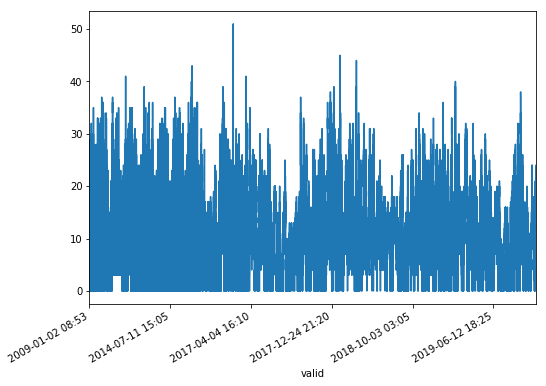

In [46]:
uni_data.plot(subplots=True)

In [47]:
uni_data = uni_data.values

It is important to normalize features before training a neural network. A common way to do so is by subtracting the mean and dividing by the standard deviation of each feature.

Note: The mean and standard deviation should only be computed using the training data.

In [48]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

print(uni_train_mean)
print(uni_train_std)

11.509175466666667
7.192141344190299


Let's normalize the data.

In [49]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [50]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the `univariate_data` function returns.

In [51]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-0.07079609]
 [-1.04408063]
 [-1.18312128]
 [-1.60024323]
 [-0.07079609]
 [-0.76599933]
 [-1.18312128]
 [-1.60024323]
 [-1.60024323]
 [-1.60024323]
 [-0.76599933]
 [-0.90503998]
 [-0.90503998]
 [-1.18312128]
 [-0.34887739]
 [-0.76599933]
 [-0.34887739]
 [-0.07079609]
 [ 0.06824456]
 [ 0.62440716]]

 Target temperature to predict
-0.07079608732633864


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [52]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [53]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Christopher Kok\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

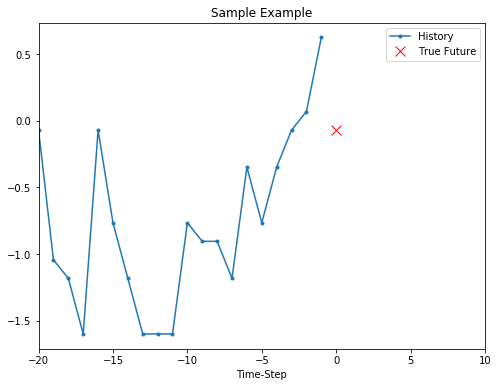

In [54]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [55]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\Christopher Kok\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

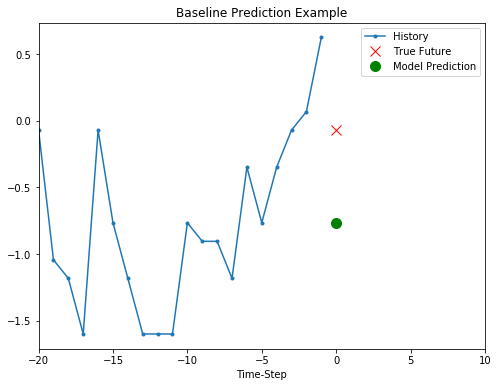

In [56]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [57]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

The following visualisation should help you understand how the data is represented after batching.

![Time Series](images/time_series.png)

You will see the LSTM requires the input shape of the data it is being given.

In [58]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model. 

In [59]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [60]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 7s 37ms/step - loss: 0.4881 - val_loss: 0.2439
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.3027 - val_loss: 0.1886
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2114 - val_loss: 0.1841
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2531 - val_loss: 0.1748
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2550 - val_loss: 0.1738
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2036 - val_loss: 0.1734
Epoch 7/10
200/200 [==============================] - 4s 20ms/step - loss: 0.2398 - val_loss: 0.1720
Epoch 8/10
200/200 [==============================] - 4s 19ms/step - loss: 0.2556 - val_loss: 0.1723
Epoch 9/10
200/200 [==============================] - 3s 17ms/step - loss: 0.2085 - val_loss: 0.1747
Epoch 10/10
200/200 [===========================

#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

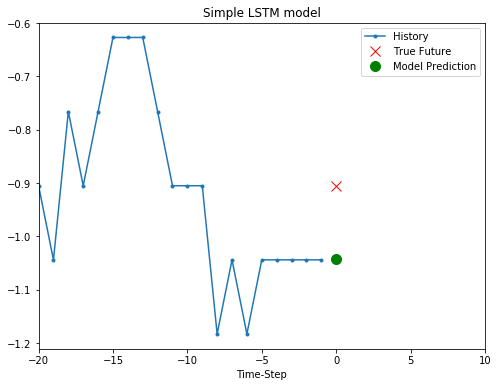

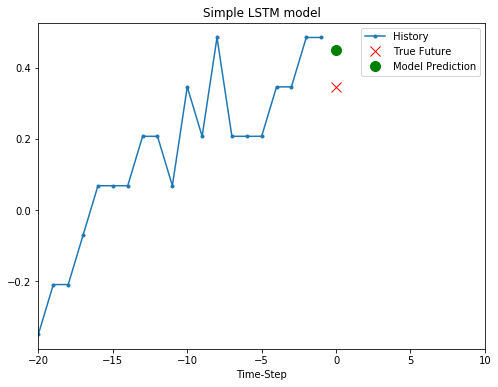

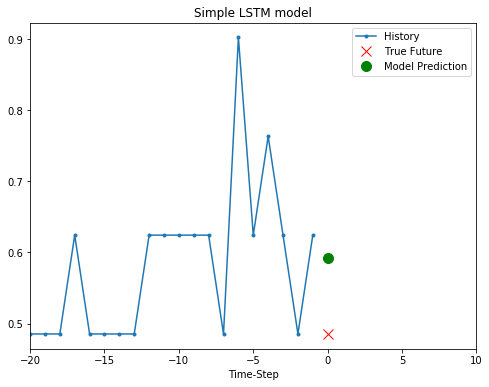

In [61]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [62]:
features_considered = ['drct', 'sknt', 'alti']

In [63]:
features = df[features_considered]
features.index = df['valid']
features.head()

,drct,sknt,alti
valid,,,
2009-01-02 08:53,310.0,11.0,29.77
2009-01-03 01:53,270.0,4.0,29.67
2009-01-03 02:53,340.0,3.0,29.67
2009-01-03 03:53,0.0,0.0,29.66
2009-01-03 04:53,300.0,11.0,29.64


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000015EE57AD940>,
      dtype=object)

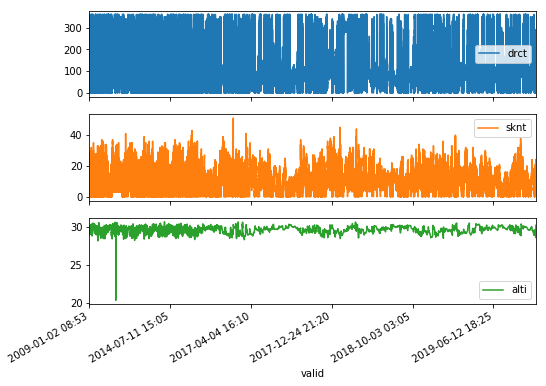

In [64]:
features.plot(subplots=True)

As mentioned, the first step will be to normalize the dataset using the mean and standard deviation of the training data.

In [65]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [66]:
dataset = (dataset-data_mean)/data_std

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [67]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

In [68]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.


In [69]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [70]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [71]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [72]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [73]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 68s 338ms/step - loss: 0.7432 - val_loss: 0.7244
Epoch 2/10
200/200 [==============================] - 70s 349ms/step - loss: 0.7256 - val_loss: 0.7571
Epoch 3/10
200/200 [==============================] - 63s 313ms/step - loss: 0.6655 - val_loss: 0.7405
Epoch 4/10
200/200 [==============================] - 70s 351ms/step - loss: 0.6990 - val_loss: 0.7574
Epoch 5/10
200/200 [==============================] - 79s 394ms/step - loss: 0.6816 - val_loss: 0.7630
Epoch 6/10
200/200 [==============================] - 87s 433ms/step - loss: 0.6170 - val_loss: 0.7454
Epoch 7/10
200/200 [==============================] - 88s 441ms/step - loss: 0.6503 - val_loss: 0.7936
Epoch 8/10
200/200 [==============================] - 86s 431ms/step - loss: 0.6537 - val_loss: 0.8072
Epoch 9/10
200/200 [==============================] - 86s 431ms/step - loss: 0.5974 - val_loss: 0.7693
Epoch 10/10
200/200 [=========

In [74]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

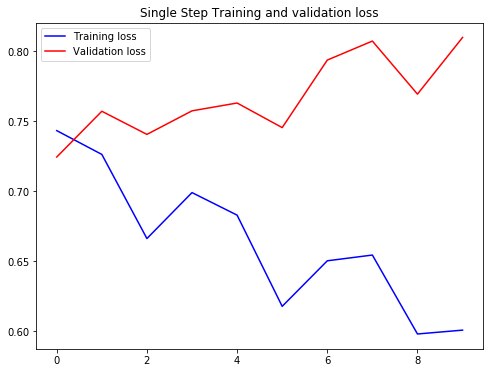

In [75]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

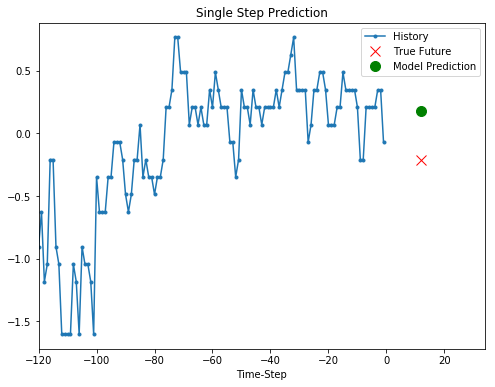

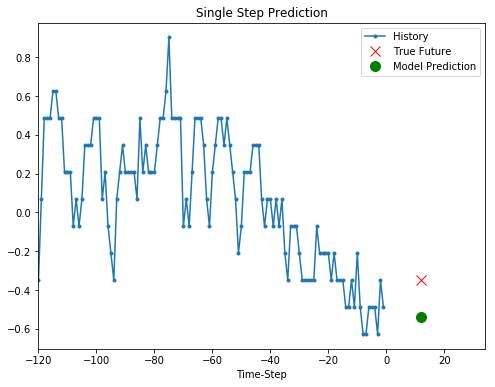

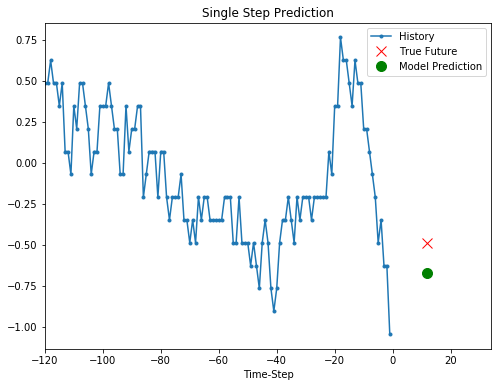

In [76]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [77]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [78]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [79]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [80]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

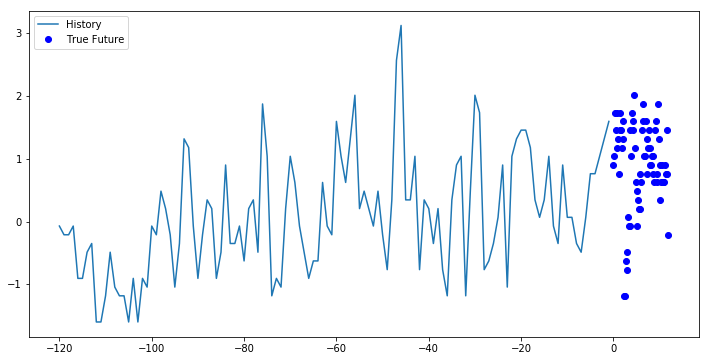

In [81]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [82]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [83]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [84]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 174s 872ms/step - loss: 0.7557 - val_loss: 0.6834
Epoch 2/10
200/200 [==============================] - 199s 993ms/step - loss: 0.7129 - val_loss: 0.6711
Epoch 3/10
200/200 [==============================] - 201s 1s/step - loss: 0.6191 - val_loss: 0.6499
Epoch 4/10
200/200 [==============================] - 176s 882ms/step - loss: 0.6682 - val_loss: 0.5994
Epoch 5/10
200/200 [==============================] - 150s 748ms/step - loss: 0.6641 - val_loss: 0.6302
Epoch 6/10
200/200 [==============================] - 142s 712ms/step - loss: 0.5860 - val_loss: 0.6809
Epoch 7/10
200/200 [==============================] - 142s 708ms/step - loss: 0.6284 - val_loss: 0.6082
Epoch 8/10
200/200 [==============================] - 143s 716ms/step - loss: 0.6472 - val_loss: 0.6289
Epoch 9/10
200/200 [==============================] - 143s 717ms/step - loss: 0.5764 - val_loss: 0.6762
Epoch 10/10
200/200 [===

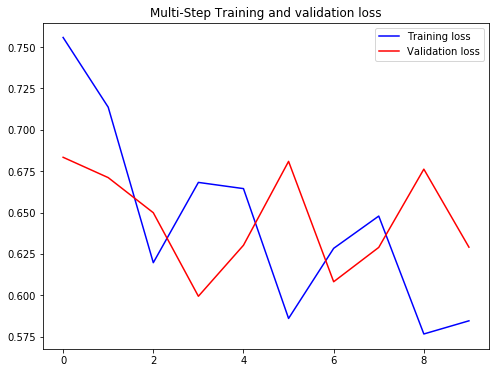

In [85]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

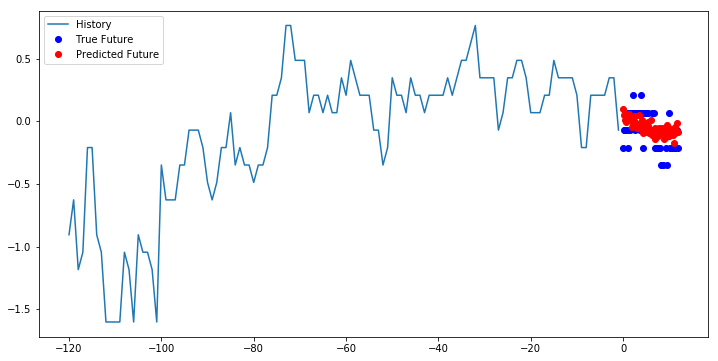

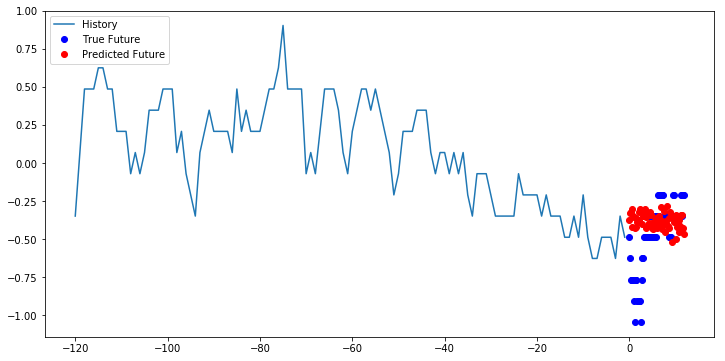

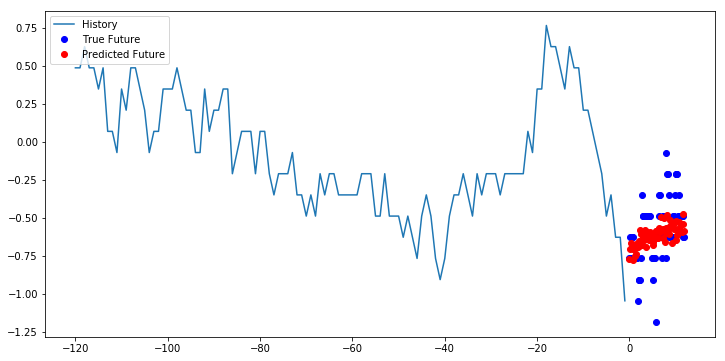

In [86]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

## Next steps
This tutorial was a quick introduction to time series forecasting using an RNN. You may now try to predict the stock market and become a billionaire.

In addition, you may also write a generator to yield data (instead of the uni/multivariate_data function), which would be more memory efficient. You may also check out this [time series windowing](https://www.tensorflow.org/guide/data#time_series_windowing) guide and use it in this tutorial.

For further understanding, you may read Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition and Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).